# Random Forest demostration -- based on Groningen case

Description: A demostration of using NetCDF dataset in Groningen case to do landcover classification. The NetCDF should include extracted 10 SAR signautres including 'VV amplitude (linear), VH amplitude (linear), VV interferometric phase (radians), VV coherence, Intensity summation, Intensity difference (dual-pol difference), Intensity ratio (dual-pol power ratio), Cross-pol correlation coefficient, Cross-pol cross product,  and Entropy'. Four layers, 'Buildings, Railways, Water, and Roads', derived from TOP10NL dataset, will be used as true labels during classification process. The employed classifier is random forest.

Authors: Xu Zhang, Ling Chang

Institution: University of Twente

Email: alignsar.project@gmail.com

1. import packages

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

2. define a function to read the required data from NetCDF into array

In [2]:
def netcdf_variables_to_array(netcdf_file):

    dataset = nc.Dataset(netcdf_file)  # open netcdf file
    variables = dataset.variables  # get the vairables list

    array_list = []  # prepare the array list to contain the variables

    for var_name, var in variables.items():  # loop in all variables
        var_data = var[:]  # assign each variable in netcdf to var_data
        np_array = np.array(var_data)  # transform var_data into numpy array
        array_list.append(np_array)  # append the following variables to the array list
        print(f"Variable: {var_name}, Shape: {np_array.shape}")

    concatenated_array = np.concatenate(array_list, axis=0)  # concatenate the arrays in line direction

    print(f"Concatenated Array Shape: {concatenated_array.shape}")

    dataset.close()
    return concatenated_array


3. read and preprocess the data for training

In [3]:
# give the path to NetCDF dataset
# the 'Groningen_netcdf_20220109_full_attributes.nc' can be download via: https://surfdrive.surf.nl/files/index.php/s/56JthYWrVaa4ZAt
# after downloading, the user can put the 'Groningen_netcdf_20220109_full_attributes.nc' to the local path
netcdf_path = '/media/xu/Elements2/AlignSAR/code/alignSAR-main_need_arg_explain/Groningen_netcdf_20220109_full_attributes.nc'
    
numpy_arr = netcdf_variables_to_array(netcdf_path)  # transform the netcdf data into numpy array

numpy_sub_arrs = [numpy_arr[i*2350:(i+1)*2350, :] for i in range(0,14)]  # separate the array into 14 arrays
numpy_sub_arr_flatten = np.array([numpy_sub_arr.flatten() for numpy_sub_arr in numpy_sub_arrs]).T  # flatten the array to be vectored, then transform them into numpy array
numpy_sub_arr_flatten = np.where(np.isnan(numpy_sub_arr_flatten), 0, numpy_sub_arr_flatten)  # remove the nan value
# plt.imshow(numpy_sub_arrs[11])

X = numpy_sub_arr_flatten[:,:10]  # divide first 10 layers as input training data
Y = numpy_sub_arr_flatten[:,10:]  # divide last 4 layers as labeling data
Y[:,0] = np.where(Y[:,0] !=0, 1, 0)  # set building layer as 1
Y[:,1] = np.where(Y[:,1] !=0, 2, 0)  # set railways layer as 2
Y[:,2] = np.where(Y[:,2] !=0, 3, 0)  # set water layer as 3
Y[:,3] = np.where(Y[:,3] !=0, 4, 0)  # set roads layer as 4

Variable: VV amplitude (linear), Shape: (2350, 940)
Variable: VH amplitude (linear), Shape: (2350, 940)
Variable: VV interferometric phase (radians), Shape: (2350, 940)
Variable: VV coherence, Shape: (2350, 940)
Variable: Intensity summation, Shape: (2350, 940)
Variable: Intensity difference (dual-pol difference), Shape: (2350, 940)
Variable: Intensity ratio (dual-pol power ratio), Shape: (2350, 940)
Variable: Cross-pol correlation coefficient, Shape: (2350, 940)
Variable: Cross-pol cross product, Shape: (2350, 940)
Variable: Entropy, Shape: (2350, 940)
Variable: Buildings, Shape: (2350, 940)
Variable: Railways, Shape: (2350, 940)
Variable: Water, Shape: (2350, 940)
Variable: Roads, Shape: (2350, 940)
Variable: Lon, Shape: (2350, 940)
Variable: Lat, Shape: (2350, 940)
Concatenated Array Shape: (37600, 940)


4. split the data to be training and test sets, define the random forest model

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)  # separate the training data

# build random forest classifier
clf = RandomForestClassifier(n_estimators=100,
    criterion='gini',  # uncertainty criterion (gini, entropy)
    max_depth=None,  # the maximum depth of single tree, if set none, it will iterate until each leaf has less numb than min_samples_split
    min_samples_split=2, # changed from 2
    min_samples_leaf=1,  # minimum leaf number of a single tree
    min_weight_fraction_leaf=0.0,  # the fraction of total leaf weight
    max_features='sqrt',  # the max feature number of single tree (sqrt: sqrt of total features; log2: log2 of total features)
    max_leaf_nodes=None,  # the maximum of leaf node
    min_impurity_decrease=0.0,  # if the impurity of leaf node decrease less than this value, it will split
    #min_impurity_split=None,
    bootstrap=True,  # True: the samples will be put back after training
    oob_score=True,  # set out of bag to score the model
    n_jobs=20,  # number of cores to use
    random_state=None, verbose=0, warm_start=False, class_weight=None)

5. train the model

In [5]:
# train the model
clf.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=20, oob_score=True)

6. predict the output for test dataset

In [6]:
# predict
Y_pred = clf.predict(X_test)

7. Assessments

In [9]:
# calculate the accuracy
accuracy_class1 = accuracy_score(Y_test[:,0], Y_pred[:,0])
accuracy_class2 = accuracy_score(Y_test[:,1], Y_pred[:,1])
accuracy_class3 = accuracy_score(Y_test[:,2], Y_pred[:,2])
accuracy_class4 = accuracy_score(Y_test[:,3], Y_pred[:,3])

# precision_recall_fscore_support test
# (precision_recall_fscore_support[0] is the precision of building and non-building)
# (precision_recall_fscore_support[1] is the recall of building and non-building)
# (precision_recall_fscore_support[1] is the f1score of building and non-building)
# (precision_recall_fscore_support[1] is the occurrences of building and non-building in Y_test)
precision_recall_fscore_class1 = precision_recall_fscore_support(Y_test[:,0], Y_pred[:,0], zero_division = np.nan)
precision_recall_fscore_class2 = precision_recall_fscore_support(Y_test[:,1], Y_pred[:,1], zero_division = np.nan)
precision_recall_fscore_class3 = precision_recall_fscore_support(Y_test[:,2], Y_pred[:,2], zero_division = np.nan)
precision_recall_fscore_class4 = precision_recall_fscore_support(Y_test[:,3], Y_pred[:,3], zero_division = np.nan)
    
# print the scores
print('# Assessment Matrix # \n'
        'Type Buildings Railway Water Roads \n'
        'Accuracy', f"{accuracy_class1:.4f}", f"{accuracy_class2:.4f}", f"{accuracy_class3:.4f}", f"{accuracy_class4:.4f} \n"
        'Precision', f"{precision_recall_fscore_class1[0][0]:.4f}", f"{precision_recall_fscore_class2[0][0]:.4f}", f"{precision_recall_fscore_class3[0][0]:.4f}", f"{precision_recall_fscore_class4[0][0]:.4f} \n"
        'Recall', f"{precision_recall_fscore_class1[1][0]:.4f}", f"{precision_recall_fscore_class2[1][0]:.4f}", f"{precision_recall_fscore_class3[1][0]:.4f}", f"{precision_recall_fscore_class4[1][0]:.4f} \n"
        'F1score', f"{precision_recall_fscore_class1[2][0]:.4f}", f"{precision_recall_fscore_class2[2][0]:.4f}", f"{precision_recall_fscore_class3[2][0]:.4f}", f"{precision_recall_fscore_class4[2][0]:.4f} \n")

# Assessment Matrix # 
Type Buildings Railway Water Roads 
Accuracy 0.8558 0.9939 0.9065 0.8191 
Precision 0.8744 0.9939 0.9141 0.8195 
Recall 0.9686 1.0000 0.9866 0.9994 
F1score 0.9191 0.9969 0.9490 0.9006 



8. use trained model to predict the landcover classes

In [10]:
layer_pred = clf.predict(X[:,:10])

# reshape the classified 4 layer as 2350*940 for later plot
class1 = layer_pred[:,0].reshape(2350,940)
class2 = layer_pred[:,1].reshape(2350,940)
class3 = layer_pred[:,2].reshape(2350,940)
class4 = layer_pred[:,3].reshape(2350,940)

9. plot results (left column is predicted classes, right column is true labels)

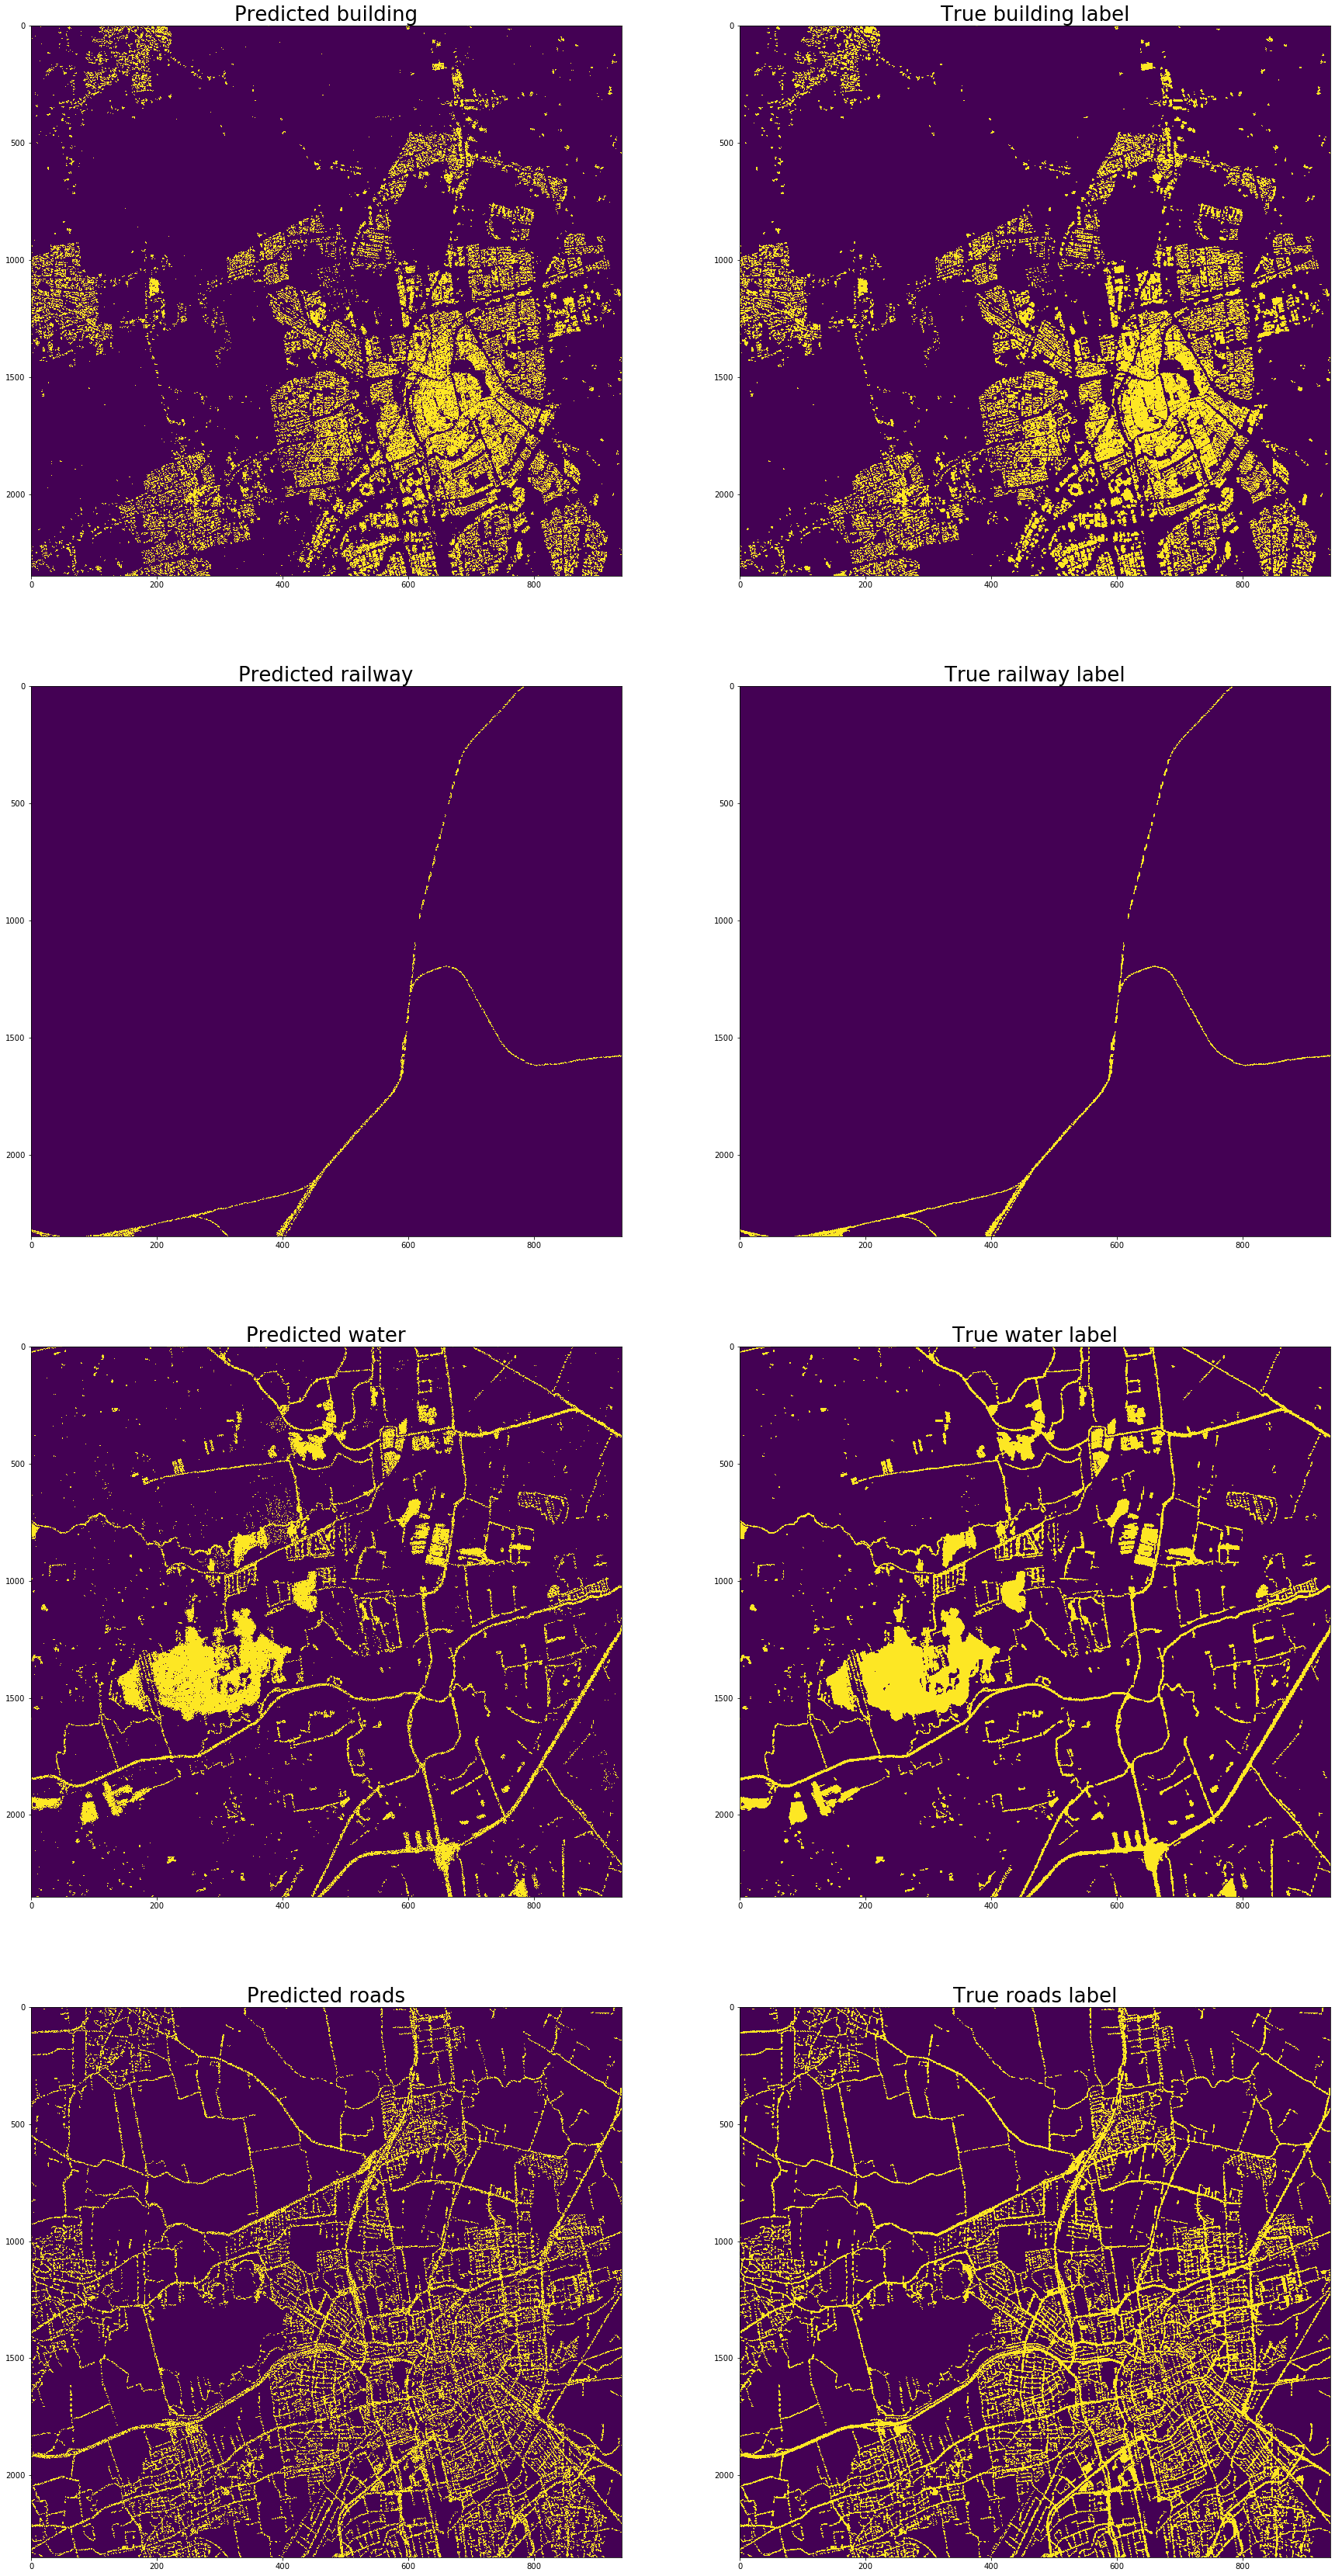

In [12]:
# plot the classification results, compared with the true labels
plt.figure(figsize=(30,60))

plt.subplot(4,2,1)
plt.imshow(class1,aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('Predicted building', fontsize=26)

plt.subplot(4,2,2)
plt.imshow(Y[:,0].reshape(2350,940),aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('True building label', fontsize=26)

plt.subplot(4,2,3)
plt.imshow(class2,aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('Predicted railway', fontsize=26)

plt.subplot(4,2,4)
plt.imshow(Y[:,1].reshape(2350,940),aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('True railway label', fontsize=26)

plt.subplot(4,2,5)
plt.imshow(class3,aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('Predicted water', fontsize=26)

plt.subplot(4,2,6)
plt.imshow(Y[:,2].reshape(2350,940),aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('True water label', fontsize=26)

plt.subplot(4,2,7)
plt.imshow(class4,aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('Predicted roads', fontsize=26)

plt.subplot(4,2,8)
plt.imshow(Y[:,3].reshape(2350,940),aspect='auto')
# plt.colorbar(label='linear',orientation='horizontal')
plt.title('True roads label', fontsize=26)

plt.show()